# Donald Trump NLP Analysis

In [16]:
# Some qu's that I will look to answer:

# What are the most common hashtags
# What are the most common hashtags used in negative / positive sentiment tweets?
# What are the most common words in the entire dataset?
# What are the most common words in the dataset for negative and positive tweets?
# Which trends are associated with my dataset?
# Can I generate a Trump tweet? (spoiler, not yet)

In [17]:
#import everything that's needed at the start

import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 

%matplotlib inline



In [70]:
conda install -c conda-forge wordcloud

Solving environment: done

## Package Plan ##

  environment location: /Users/bethdougall/opt/anaconda3

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-base-3.1.3      |   py37h9aa3819_0         4.9 MB
    wordcloud-1.6.0            |   py37h0b31af3_0         167 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following NEW packages will be INSTALLED:

  matplotlib-base    pkgs/main/osx-64::matplotlib-base-3.1.3-py37h9aa3819_0
  wordcloud          conda-forge/osx-64::wordcloud-1.6.0-py37h0b31af3_0



wordcloud-1.6.0      | 167 KB    | ##################################### | 100% 
matplotlib-base-3.1. | 4.9 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transact

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

ModuleNotFoundError: No module named 'keras'

In [18]:
#this is a webscrape of DT's twitter account using Twint - https://github.com/twintproject/twint
dt_df = pd.read_csv('donaldtrump.csv')

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
#check the dataframe looks okay
dt_df.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,likes_count,hashtags,cashtags,link,retweet,quote_url,video,user_rt_id,near,geo
0,1179422987684077568,1179422987684077568,1570031327000,2019-10-02,16:48:47,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,63216,[],[],https://twitter.com/realDonaldTrump/status/117...,NaN,NaN,0,NaN,NaN,NaN
1,1179420554601910272,1179420554601910272,1570030747000,2019-10-02,16:39:07,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,41745,[],[],https://twitter.com/realDonaldTrump/status/117...,NaN,NaN,0,NaN,NaN,NaN
2,1179418734764711937,1179418734764711937,1570030313000,2019-10-02,16:31:53,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,31185,[],[],https://twitter.com/realDonaldTrump/status/117...,NaN,NaN,1,NaN,NaN,NaN


In [20]:
#check the number of rows and collumns
dt_df.shape

(39520, 26)

In [21]:
#check the data types available
dt_df.dtypes

id                   int64
conversation_id      int64
created_at           int64
date                object
time                object
timezone            object
user_id              int64
username            object
name                object
place               object
tweet               object
mentions            object
urls                object
photos              object
replies_count        int64
retweets_count       int64
likes_count          int64
hashtags            object
cashtags            object
link                object
retweet            float64
quote_url           object
video                int64
user_rt_id         float64
near               float64
geo                float64
dtype: object

In [22]:
#find all missing values to analyse why these are missing
print((dt_df.isnull().sum()))

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              39443
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet            39520
quote_url          38879
video                  0
user_rt_id         39520
near               39520
geo                39520
dtype: int64


In [23]:
#drop the last 3 collumns. 
#As DT sadly is president his security is significant hence why no live geo tags and locations are included
dt_df = dt_df.drop(['user_rt_id', 'near', 'geo'], axis=1)

In [24]:
#double check these are dropped
print((dt_df.isnull().sum()))
dt_df.shape

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              39443
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet            39520
quote_url          38879
video                  0
dtype: int64


(39520, 23)

In [25]:
#id and conversation_id are simply a unique ref for each individual tweet
dt_df.describe()

,id,conversation_id,created_at,user_id,replies_count,retweets_count,likes_count,retweet,video
count,3.952000e+04,3.952000e+04,3.952000e+04,39520.0,39520.000000,39520.000000,39520.000000,0.0,39520.000000
mean,5.850406e+17,5.850214e+17,1.428224e+12,25073877.0,4232.932009,5008.560855,20226.664929,NaN,0.030086
std,2.842770e+17,2.842947e+17,6.799601e+10,0.0,10166.906712,9750.929789,39037.242713,NaN,0.170826
min,1.698309e+09,1.698309e+09,1.241463e+12,25073877.0,0.000000,0.000000,0.000000,NaN,0.000000
25%,3.486351e+17,3.486351e+17,1.371956e+12,25073877.0,16.000000,23.000000,26.000000,NaN,0.000000
50%,5.522711e+17,5.522710e+17,1.420507e+12,25073877.0,86.000000,234.000000,189.000000,NaN,0.000000
75%,7.563158e+17,7.563158e+17,1.469155e+12,25073877.0,2123.250000,6382.000000,18004.500000,NaN,0.000000
max,1.179423e+18,1.179423e+18,1.570031e+12,25073877.0,142995.000000,315775.000000,874137.000000,NaN,1.000000


In [26]:
#change the date from obj to date type
dt_df['date'] = pd.to_datetime(dt_df['date'])

In [27]:
#check the type for date has been changed successfully 
dt_df['date'].dtype

dtype('<M8[ns]')

In [28]:
#sort the date
dt_df = dt_df.set_index(dt_df['date'])
dt_df = dt_df.sort_index()

In [29]:
#create 2 dataframes - when DT became president (pre president and president)
dooms_day = '2017-01-20'
pre_pres = dt_df[:dooms_day]
pres = dt_df[dooms_day:]


In [30]:
#double check dates
pre_pres.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video
date,,,,,,,,,,,,,,,,,,,,,
2009-05-04,1698308935,1698308935,1241463265000,2009-05-04,19:54:25,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,[],184,498,857,[],[],https://twitter.com/realDonaldTrump/status/169...,NaN,NaN,0
2009-05-05,1701461182,1701461182,1241485210000,2009-05-05,02:00:10,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,[],23,33,278,[],[],https://twitter.com/realDonaldTrump/status/170...,NaN,NaN,0
2009-05-08,1741160716,1741160716,1241815215000,2009-05-08,21:40:15,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,[],9,11,27,[],[],https://twitter.com/realDonaldTrump/status/174...,NaN,NaN,0


In [31]:
#double check dates - this analysis will mainly focus on the pres data
pres.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video
date,,,,,,,,,,,,,,,,,,,,,
2017-01-20,822502887477673984,822502887477673984,1484934944000,2017-01-20,17:55:44,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,[],17703,33309,146800,"['#inaugurationday', '#maga']",[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0
2017-01-20,822507434396753921,822507434396753921,1484936028000,2017-01-20,18:13:48,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,[],13021,14407,83362,[],[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0
2017-01-20,822504142178500608,822504142178500608,1484935243000,2017-01-20,18:00:43,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,[],6954,12319,78613,[],[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0


In [32]:
#total likes since pres
pres['likes_count'].sum()

698269413

In [33]:
#total retweets since pres
pres['retweets_count'].sum()

157807069

In [34]:
#total replis since pres
pres['replies_count'].sum()

151460845

In [35]:
#most liked tweet
print(pres[['tweet', 'likes_count']][pres.likes_count == pres.likes_count.max()])

                                                        tweet  likes_count
date                                                                      
2019-08-02  A$AP Rocky released from prison and on his way...       874137


In [36]:
gbd = pres.groupby(by=pres['date'].dt.date).count()

In [37]:
# 31 tweets in one day!
gbd.max()

id                 31
conversation_id    31
created_at         31
date               31
time               31
timezone           31
user_id            31
username           31
name               31
place               1
tweet              31
mentions           31
urls               31
photos             31
replies_count      31
retweets_count     31
likes_count        31
hashtags           31
cashtags           31
link               31
retweet             0
quote_url          11
video              31
dtype: int64

In [38]:
#extract all hashtags, there are several tweets with no or multiple hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the hashtag column
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [39]:
#call the above function where x = value in the hashtag column
all_hashtags = hashtag_extract(pres['hashtags'])

# unnesting list
all_hashtags = sum(all_hashtags,[])

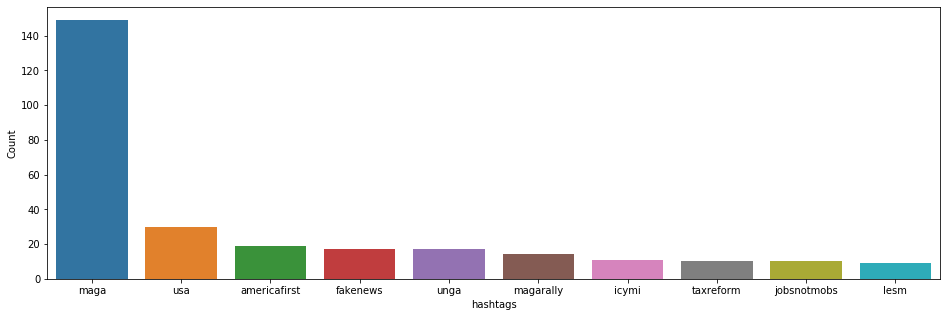

In [40]:
#a is the frequency of the hashtag using nltk library, 
a = nltk.FreqDist(all_hashtags)
d = pd.DataFrame({'hashtags': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "hashtags", y = "Count")
ax.set(ylabel = 'Count')
plt.show()
#icymi = in case you missed it, unga = united nations general assembly

In [41]:
#create a function to find a specific pattern within the string 'tweet' and remove this
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [42]:
#drop any tagged people as these are contained in a seperate column
pres['tidy_tweet'] = np.vectorize(remove_pattern)(pres['tweet'], "@[\w]*")

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
pres.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,tidy_tweet
date,,,,,,,,,,,,,,,,,,,,,
2017-01-20,822502887477673984,822502887477673984,1484934944000,2017-01-20,17:55:44,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,17703,33309,146800,"['#inaugurationday', '#maga']",[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0,We will follow two simple rules: BUY AMERICAN ...
2017-01-20,822507434396753921,822507434396753921,1484936028000,2017-01-20,18:13:48,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,13021,14407,83362,[],[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0,TO ALL AMERICANS🇺🇸 https://www.facebook.com/D...
2017-01-20,822504142178500608,822504142178500608,1484935243000,2017-01-20,18:00:43,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,6954,12319,78613,[],[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0,"So to all Americans, in every city near and fa..."


In [44]:
# remove special characters, numbers, punctuations
pres['tidy_tweet'] = pres['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
#tokenize all the cleaned tweets in dataset
#Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.
tokenized_tweet = pres['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

date
2017-01-20    [We, will, follow, two, simple, rules, BUY, AM...
2017-01-20    [TO, ALL, AMERICANS, https, www, facebook, com...
2017-01-20    [So, to, all, Americans, in, every, city, near...
2017-01-20    [It, is, time, to, remember, that, https, www,...
2017-01-20    [The, forgotten, men, and, women, of, our, cou...
Name: tidy_tweet, dtype: object

In [46]:
#Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. 
#For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

date
2017-01-20    [We, will, follow, two, simpl, rule, buy, amer...
2017-01-20    [TO, all, american, http, www, facebook, com, ...
2017-01-20    [So, to, all, american, in, everi, citi, near,...
2017-01-20    [It, is, time, to, rememb, that, http, www, fa...
2017-01-20    [the, forgotten, men, and, women, of, our, cou...
Name: tidy_tweet, dtype: object

In [47]:
#like humpty dumpty, put it back together again in the pres column 'tidy_tweet'
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

pres['tidy_tweet'] = tokenized_tweet

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [48]:
#check this has worked
pres.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,tidy_tweet
date,,,,,,,,,,,,,,,,,,,,,
2017-01-20,822502887477673984,822502887477673984,1484934944000,2017-01-20,17:55:44,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,17703,33309,146800,"['#inaugurationday', '#maga']",[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0,We will follow two simpl rule buy american hir...
2017-01-20,822507434396753921,822507434396753921,1484936028000,2017-01-20,18:13:48,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,13021,14407,83362,[],[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0,TO all american http www facebook com donaldtr...
2017-01-20,822504142178500608,822504142178500608,1484935243000,2017-01-20,18:00:43,GMT Summer Time,25073877,realdonaldtrump,Donald J. Trump,NaN,...,6954,12319,78613,[],[],https://twitter.com/realDonaldTrump/status/822...,NaN,NaN,0,So to all american in everi citi near and far ...


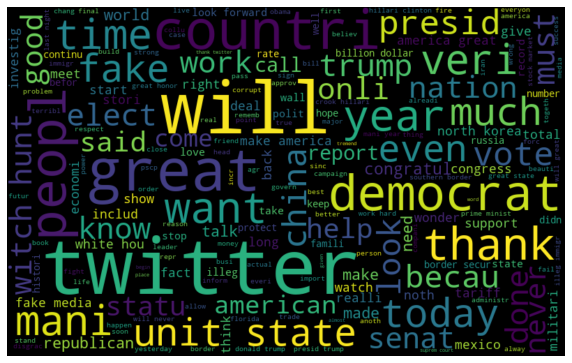

In [71]:
# What are the most common words in the entire dataset?
#this joins all the words in the column 'Tidy_tweet' 
#Then uses wordcloud to visualise the most commonly used words
all_words = ' '.join([text for text in pres['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [50]:
#due to the above we are now going to remove all words with 2 letters or less to clean the data
pres['tidy_tweet'] = pres['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
#tokenize all the cleaned tweets in our dataset. 
#Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.
tokenized_tweet = pres['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

date
2017-01-20    [will, follow, simpl, rule, american, hire, am...
2017-01-20        [american, http, facebook, donaldtrump, post]
2017-01-20    [american, everi, citi, near, small, larg, fro...
2017-01-20    [time, rememb, that, http, facebook, donaldtru...
2017-01-20    [forgotten, women, countri, will, forgotten, l...
Name: tidy_tweet, dtype: object

In [52]:
#Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. 
#For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

date
2017-01-20    [will, follow, simpl, rule, american, hire, am...
2017-01-20        [american, http, facebook, donaldtrump, post]
2017-01-20    [american, everi, citi, near, small, larg, fro...
2017-01-20    [time, rememb, that, http, facebook, donaldtru...
2017-01-20    [forgotten, women, countri, will, forgotten, l...
Name: tidy_tweet, dtype: object

In [53]:
#like humpty dumpty, put it back together again
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

pres['tidy_tweet'] = tokenized_tweet

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [61]:
all_words = ' '.join([text for text in pres['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [62]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(pres['tidy_tweet'])


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(pres['tidy_tweet'])

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [65]:
#text blob is a library that contains a sentiment polarity scoring system -1 negative, 0 neutral, 1 positive
from textblob import TextBlob

In [66]:
#check and test on a random row
tweet1 = pres['tidy_tweet'][8]
print(tweet1)

begin today will swear movement continu work begin


In [67]:
bloob1 = TextBlob(tweet1)

In [68]:
#print the polarity score to identify whether negative, neutral or positive
bloob1.sentiment.polarity

0.0

In [69]:
#create a new column called 'polarity', where textblob sentiment polarity is applied to 'tidy tweet' column
pres['polarity'] = pres['tidy_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

/Users/bethdougall/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
#double check this has worked
pres['polarity'].describe()

count    8263.000000
mean        0.165763
std         0.319473
min        -1.000000
25%         0.000000
50%         0.061111
75%         0.375000
max         1.000000
Name: polarity, dtype: float64

In [62]:
#return the tidy tweets with the lowest polarity score
pres[pres['polarity'] < -0.5][['tidy_tweet', 'polarity']]

,tidy_tweet,polarity
date,,
2017-02-03,must keep evil countri,-1.000000
2017-02-06,call shot larg base accumul data everyon know ...,-0.650000
2017-02-15,aetna obamacar death spiral #repealandreplac h...,-0.714286
2017-03-13,obamacar implod disast will worst year republi...,-1.000000
2017-05-10,democrat have said some worst thing about jame...,-1.000000
2017-05-26,terrorist engag against civil valu life confro...,-1.000000
2017-05-31,kathi griffin should asham herself children es...,-0.502976
2017-06-13,fake media never been wrong dirti purpo incorr...,-0.600000
2017-06-27,they caught fake cold what about what about fa...,-0.525000


In [76]:
#define a variable with the most negitive and positive polarity
neg = pres[pres['polarity'] < -0.5][['tidy_tweet', 'polarity', 'tweet', 'hashtags']]
pos = pres[pres['polarity'] > 0.5][['tidy_tweet', 'polarity', 'tweet', 'hashtags']]

In [77]:
neg.head(3)

,tidy_tweet,polarity,tweet,hashtags
date,,,,
2017-02-03,must keep evil countri,-1.000000,"We must keep ""evil"" out of our country!",[]
2017-02-06,call shot larg base accumul data everyon know ...,-0.650000,"I call my own shots, largely based on an accum...",[]
2017-02-15,aetna obamacar death spiral #repealandreplac h...,-0.714286,Aetna CEO: Obamacare in 'Death Spiral' #Repeal...,['#repealandreplace']


In [75]:
pos.head(3)

,tidy_tweet,polarity,tweet,hashtags
date,,,,
2017-01-20,thank join lincoln memori tonight veri special...,0.578571,Thank you for joining us at the Lincoln Memori...,[]
2017-01-21,thank anoth wonder even washington togeth will...,0.800000,THANK YOU for another wonderful evening in Was...,[]
2017-01-22,great meet headquart yesterday pack hou paid g...,0.516667,Had a great meeting at CIA Headquarters yester...,[]


In [69]:
neg_all_words = ' '.join([text for text in neg['tidy_tweet']])
pos_all_words = ' '.join([text for text in pos['tidy_tweet']])

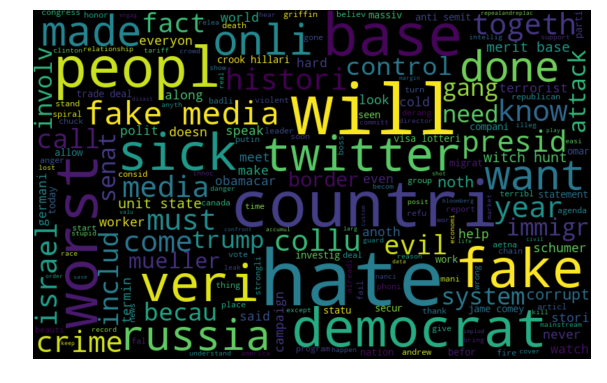

In [70]:
#create a word cloud for negative sentiment
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

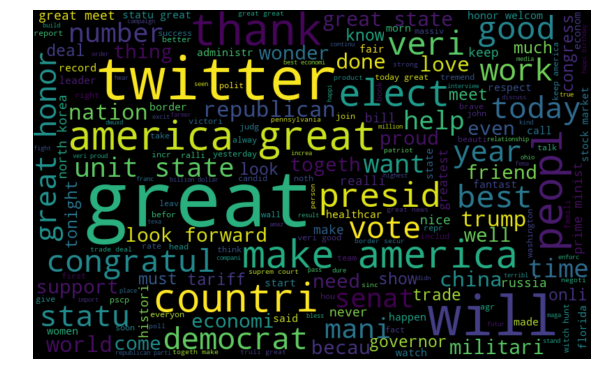

In [71]:
#create a word cloud for positive sentiment
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [89]:
#call the above function where x = value in the hashtag column
all_hashtags = hashtag_extract(neg['hashtags'])

# unnesting list
all_hashtags = sum(all_hashtags,[])

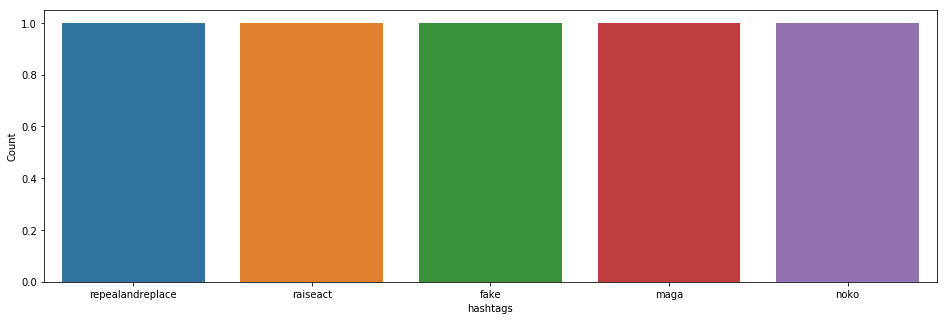

In [90]:
#a is the frequency of the neg hashtag using nltk library, unga = united nations general assembly
a = nltk.FreqDist(all_hashtags)
d = pd.DataFrame({'hashtags': list(a.keys()),
                  'Count': list(a.values())})
# selecting top most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "hashtags", y = "Count")
ax.set(ylabel = 'Count')
plt.show()
#appears to have fewer neg than pos tweets

In [97]:
#way more positive tweets but they often have a neg under-tone. Really interesting and will look into more
pos.shape

(1200, 4)

In [98]:
neg.shape

(69, 4)

In [86]:
#call the above function where x = value in the hashtag column
all_hashtags = hashtag_extract(pos['hashtags'])

# unnesting list
all_hashtags = sum(all_hashtags,[])

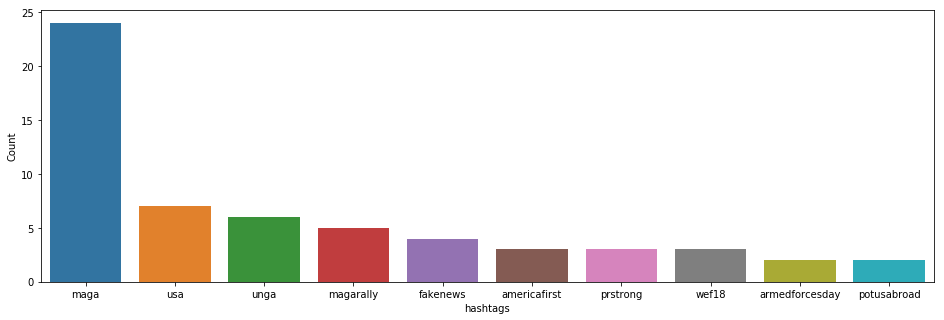

In [87]:
#a is the frequency of the pos hashtag using nltk library, unga = united nations general assembly
a = nltk.FreqDist(all_hashtags)
d = pd.DataFrame({'hashtags': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "hashtags", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


In [6]:
#experimenting with a recurrent neural net
from textgenrnn import textgenrnn
textgen = textgenrnn()

Instructions for updating:
Colocations handled automatically by placer.


In [93]:
#create one giant trump tweet
all_words = ' '.join([text for text in pres['tidy_tweet']])

In [94]:
#save all trump tweets in one string in a txt file (just to make sure it worked)
f = open("trump.txt", "w")
f.write(all_words)

1296166

In [138]:
#update in keras so this no longer works, very sad
textgen = textgenrnn()
textgen.train_from_file('trump.txt', is_csv = True, num_epochs=10)
textgen.generate(5)


0 texts collected.


ValueError: List at arrays cannot be empty

In [98]:
#attempt 2

In [149]:
#creating character level mappings - Character-Level Language Models i.e. the prob of the next letter
#assign an arbitrary number to a character/word in the text
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

In [150]:
#data preprocessing. X is the train and Y is the target
X = []
Y = []
length = len(text)
seq_length = 100
for i in range(0, length-seq_length, 1):
    sequence = text[i:i + seq_length]
    label =text[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])

In [151]:
#transform the array Y into a one-hot encoded format

#reshape the array X into our required dimensions
X_modified = np.reshape(X, (len(X), seq_length, 1))

#scale the values of our X_modified so that our neural network can train faster 
X_modified = X_modified / float(len(characters))

#Y_modified is one-hot encoded to remove any ordinal relationship
Y_modified = np_utils.to_categorical(Y)

In [157]:
model = Sequential()
model.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(Y_modified.shape[1], activation='softmax'))

In [159]:
string_mapped = X[150]
# generating characters - didn't work very well
for i in range(seq_length):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(characters))
    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in string_mapped]
    string_mapped.append(pred_index)
    string_mapped = string_mapped[1:len(string_mapped)]

In [161]:
print(seq)

['d', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']


In [ ]:
# try again...

In [135]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

In [140]:

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RNN
from keras.utils import np_utils

In [141]:
text = (open("trump.txt").read())
text=text.lower()

In [142]:
characters = sorted(list(set(text)))

n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}


In [143]:
X = []
Y = []
length = len(text)
seq_length = 100

for i in range(0, length-seq_length, 1):
    sequence = text[i:i + seq_length]
    label =text[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])

In [144]:

X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

In [145]:
model = Sequential()
model.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(Y_modified.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [148]:
#really need more computational power to train a rnn 
model.fit(X_modified, Y_modified, epochs=5, batch_size=100)

model.save_weights('text_generator_400_0.2_400_0.2_100.h5')

Epoch 1/5
1248700/1296066 [===========================>..] - ETA: 12:36 - loss: 1.5431

KeyboardInterrupt: 

In [ ]:
#reload the appropriate weights 
model.load_weights('text_generator_400_0.2_400_0.2_100.h5')

In [ ]:

string_mapped = X[99]
full_string = [n_to_char[value] for value in string_mapped]
# generating characters
for i in range(400):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(characters))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in string_mapped]
    full_string.append(n_to_char[pred_index])

    string_mapped.append(pred_index)
    string_mapped = string_mapped[1:len(string_mapped)]